<a href="https://colab.research.google.com/github/ebbilge/Lung-CA-CNN/blob/main/CNN_for_Lung_CA_60_65.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import keras

from keras import layers
from numpy import save
from keras.optimizers import schedules

In [ ]:
from scipy import ndimage

#Reading preprocess and dicom scans
def read_scan(path):
    data = np.load(path)        
    return data

def normalize(volume):
    #Normalize the volume(Can be optimize?)
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def padding(img, dd):
    #Padding scans that depth-size smaller than 200(Is this necessary? Research about it.)
    
    d = img.shape[0]
    
    a = (dd - d) // 2
    aa = dd - a - d

    img = np.pad(img, ((a,aa), (0,0), (0, 0)), 'constant')
    return img

def resize_volume(img):

    # Set the desired depth
    desired_depth = 200
    desired_width = 128
    desired_height = 128

    # Get current depth
    current_depth = img.shape[0]
    current_width = img.shape[1]
    current_height = img.shape[2]

    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    
    # Resize across z-axis
    img = ndimage.zoom(img, (depth_factor, width_factor, height_factor), order=1)
    return img


def process_scan(path):
    
    volume = read_scan(path)
    volume = normalize(volume)
    if(volume.shape[0]<200):
        volume = padding(volume,200)
    volume = resize_volume(volume)

    #Is reshaping necessary?

    return volume


In [ ]:
#Reading train scans from paths
train_adeno_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/hu_scans_128/train_adeno", x)
    for x in os.listdir("/content/drive/MyDrive/hu_scans_128/train_adeno")
]

train_scc_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/hu_scans_128/train_scc", x)
    for x in os.listdir("/content/drive/MyDrive/hu_scans_128/train_scc")
]

#Reading validation scans from paths
val_adeno_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/hu_scans_128/val_adeno", x)
    for x in os.listdir("/content/drive/MyDrive/hu_scans_128/val_adeno")
]

val_scc_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/hu_scans_128/val_scc", x)
    for x in os.listdir("/content/drive/MyDrive/hu_scans_128/val_scc")
]


print("CT scans with adeno lung tissue: " + str(len(train_adeno_scan_paths )+len(val_adeno_scan_paths)))
print("CT scans with scc lung tissue: " + str(len(train_scc_scan_paths)+len(val_scc_scan_paths)))


CT scans with adeno lung tissue: 45
CT scans with scc lung tissue: 38


In [ ]:

train_adeno_scans = np.array([process_scan(path) for path in train_adeno_scan_paths])
train_scc_scans = np.array([process_scan(path) for path in train_scc_scan_paths])
#train_normal_scans = np.array([process_scan(path) for path in train_normal_scan_paths])

val_adeno_scans = np.array([process_scan(path) for path in val_adeno_scan_paths])
val_scc_scans = np.array([process_scan(path) for path in val_scc_scan_paths])
#val_normal_scans = np.array([process_scan(path) for path in val_normal_scan_paths])


train_adeno_labels = np.array([0 for _ in range(len(train_adeno_scans))])
train_scc_labels = np.array([1 for _ in range(len(train_scc_scans))])
#train_normal_labels = np.array([0 for _ in range(len(train_normal_scans))])

val_adeno_labels = np.array([0 for _ in range(len(val_adeno_scans))])
val_scc_labels = np.array([1 for _ in range(len(val_scc_scans))])
#val_normal_labels = np.array([0 for _ in range(len(val_normal_scans))])



In [ ]:
test_adeno_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/test_adeno", x)
    for x in os.listdir("/content/drive/MyDrive/test_adeno")
]

test_scc_scan_paths = [
    os.path.join(os.getcwd(), "/content/drive/MyDrive/test_scc", x)
    for x in os.listdir("/content/drive/MyDrive/test_scc")
]
test_adeno_scans = np.array([process_scan(path) for path in test_adeno_scan_paths])
test_scc_scans = np.array([process_scan(path) for path in test_scc_scan_paths])

test_adeno_labels = np.array([0 for _ in range(len(test_adeno_scans))])
test_scc_labels = np.array([1 for _ in range(len(test_scc_scans))])

In [ ]:

x_train = np.concatenate((train_adeno_scans,train_scc_scans), axis=0)
#x_train = np.concatenate((x_train,train_normal_scans), axis=0)
y_train = np.concatenate((train_adeno_labels,train_scc_labels), axis=0)
#y_train = np.concatenate((y_train,train_normal_labels), axis=0)

x_val = np.concatenate((val_adeno_scans,val_scc_scans), axis=0)
#x_val = np.concatenate((x_train,val_normal_scans), axis=0)

y_val = np.concatenate((val_adeno_labels,val_scc_labels), axis=0)
#y_val = np.concatenate((y_train,val_normal_labels), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 63 and 20.


In [ ]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
def get_model(depth=200, width=128, height=128):
    
    inputs = keras.Input((depth, width, height, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    
    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)


    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)


    outputs = layers.Dense(units=1, activation="sigmoid")(x)


    model = keras.Model(inputs, outputs, name="3Dcnn")
    return model


model = get_model(depth=200,width=128, height=128)
model.summary()


Model: "3Dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 128, 128, 1  0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 198, 126, 126, 64  1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 99, 63, 63, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 99, 63, 63, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 97, 61, 61, 64)    110656

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification3.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=20)

# Train the model, doing validation at the end of each epoch
epochs = 80
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/80
32/32 - 48s - loss: 0.7193 - acc: 0.5397 - val_loss: 0.7229 - val_acc: 0.5500 - 48s/epoch - 2s/step
Epoch 2/80
32/32 - 35s - loss: 0.6943 - acc: 0.5873 - val_loss: 0.7973 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 3/80
32/32 - 35s - loss: 0.6944 - acc: 0.4762 - val_loss: 1.0712 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 4/80
32/32 - 35s - loss: 0.7062 - acc: 0.5079 - val_loss: 0.9890 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 5/80
32/32 - 35s - loss: 0.6874 - acc: 0.5714 - val_loss: 0.9016 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 6/80
32/32 - 35s - loss: 0.6949 - acc: 0.5079 - val_loss: 0.9430 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 7/80
32/32 - 35s - loss: 0.6973 - acc: 0.5556 - val_loss: 0.7077 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 8/80
32/32 - 35s - loss: 0.6792 - acc: 0.5714 - val_loss: 0.7058 - val_acc: 0.5500 - 35s/epoch - 1s/step
Epoch 9/80
32/32 - 35s - loss: 0.6539 - acc: 0.6667 - val_loss: 0.9623 - val_acc: 0.5500 - 35s/epoch - 1s/step
E

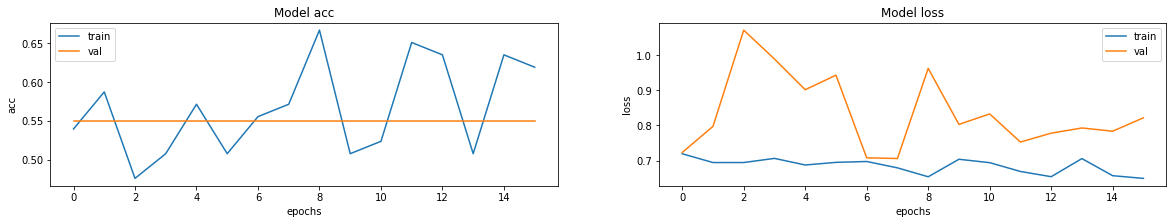

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
model.load_weights("3d_image_classification3.h5")
for i in range(11):
  prediction = model.predict(np.expand_dims(test_adeno_scans[i], axis=0))[0]
  scores = [1 - prediction[0], prediction[0]]
  
  class_names = ["adeno", "scc"]
  for score, name in zip(scores, class_names):
    print(
      "This model is %.2f percent confident that CT scan is %s"
      % ((100 * score), name)
    )

1/1 [==============================] - 0s 21ms/step
This model is 63.72 percent confident that CT scan is adeno
This model is 36.28 percent confident that CT scan is scc
1/1 [==============================] - 0s 24ms/step
This model is 63.53 percent confident that CT scan is adeno
This model is 36.47 percent confident that CT scan is scc
1/1 [==============================] - 0s 21ms/step
This model is 63.27 percent confident that CT scan is adeno
This model is 36.73 percent confident that CT scan is scc
1/1 [==============================] - 0s 22ms/step
This model is 64.13 percent confident that CT scan is adeno
This model is 35.87 percent confident that CT scan is scc
1/1 [==============================] - 0s 23ms/step
This model is 65.54 percent confident that CT scan is adeno
This model is 34.46 percent confident that CT scan is scc
1/1 [==============================] - 0s 21ms/step
This model is 64.87 percent confident that CT scan is adeno
This model is 35.13 percent confident 

In [ ]:
model.load_weights("3d_image_classification3.h5")
for i in range(9):
  prediction = model.predict(np.expand_dims(test_scc_scans[i], axis=0))[0]
  scores = [prediction[0],1 - prediction[0]]
  
  class_names = ["adeno", "scc"]
  for score, name in zip(scores, class_names):
    print(
      "This model is %.2f percent confident that CT scan is %s"
      % ((100 * score), name)
    )

1/1 [==============================] - 0s 24ms/step
This model is 39.20 percent confident that CT scan is adeno
This model is 60.80 percent confident that CT scan is scc
1/1 [==============================] - 0s 22ms/step
This model is 35.71 percent confident that CT scan is adeno
This model is 64.29 percent confident that CT scan is scc
1/1 [==============================] - 0s 23ms/step
This model is 36.30 percent confident that CT scan is adeno
This model is 63.70 percent confident that CT scan is scc
1/1 [==============================] - 0s 21ms/step
This model is 36.86 percent confident that CT scan is adeno
This model is 63.14 percent confident that CT scan is scc
1/1 [==============================] - 0s 20ms/step
This model is 35.78 percent confident that CT scan is adeno
This model is 64.22 percent confident that CT scan is scc
1/1 [==============================] - 0s 24ms/step
This model is 36.33 percent confident that CT scan is adeno
This model is 63.67 percent confident 